# Pareto Curve Analysis - Redone
This notebook provides a clean implementation of Pareto frontier visualization with proper step function support.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [15]:
def calculate_pareto_frontier(df, price_col, error_col):
    """
    Calculate the Pareto frontier - points where no other point is both cheaper AND better.
    
    A point is on the Pareto frontier if it is NOT dominated by any other point.
    Point B dominates point A if:
    - B has lower or equal price AND lower or equal error
    - AND at least one is strictly better
    """
    if len(df) == 0:
        return df
    
    df_work = df.reset_index(drop=True).copy()
    pareto_indices = []
    
    for i in range(len(df_work)):
        is_dominated = False
        row_i = df_work.iloc[i]
        
        for j in range(len(df_work)):
            if i == j:
                continue
            
            row_j = df_work.iloc[j]
            
            # Point i is dominated if j is both cheaper-or-equal AND better-or-equal (with at least one strict)
            if (row_j[price_col] <= row_i[price_col] and 
                row_j[error_col] <= row_i[error_col] and
                (row_j[price_col] < row_i[price_col] or row_j[error_col] < row_i[error_col])):
                is_dominated = True
                break
        
        if not is_dominated:
            pareto_indices.append(i)
    
    # Return sorted by price
    pareto_df = df_work.loc[pareto_indices].sort_values(price_col).copy()
    return pareto_df

In [16]:
def plot_pareto_curves(
    df,
    price_col='Benchmark Cost USD',
    benchmark_col='MMLU-Pro (Reasoning & Knowledge)',
    color_by='open_weight',
    moe_col=None,
    show_model_names=False,
    time_periods=None,
    include_current=True,
    open_license_only=False,
    extend_frontier=True,
    min_xlim=None,
    xmin=None,
    xmax=None,
    ymin=None,
    ymax=None,
    figsize=(7.0, 6.0),  # Matching gpqa_pareto_names.py for ICML side-by-side
    title=None,
    save_path=None,
    frontier_style='step'
):
    """
    Plot Pareto curves with proper step function visualization.
    
    Parameters:
        extend_frontier: If True, extend frontier lines to cover full axis space
        min_xlim: Minimum x-axis limit (left bound). If None, uses automatic scaling. (Deprecated: use xmin instead)
        xmin: Minimum x-axis limit (left bound). If None, uses automatic scaling.
        xmax: Maximum x-axis limit (right bound). If None, uses automatic scaling.
        ymin: Minimum y-axis limit (bottom bound). If None, uses automatic scaling.
        ymax: Maximum y-axis limit (top bound). If None, uses automatic scaling.
    
    frontier_style options:
    - 'points': Show only Pareto points (no connecting lines)
    - 'lines': Connect points with straight diagonal lines
    - 'step': Proper step function (horizontal then vertical)
    """
    
    # Font sizes (matching gpqa_pareto_names.py for ICML side-by-side)
    TICK_LABELSIZE = 12
    AXIS_LABELSIZE = 14
    TITLE_FONTSIZE = 16
    LEGEND_FONTSIZE = 11
    ANNOTATE_FONTSIZE = 9
    POINT_SIZE_SCATTER = 80
    PARETO_POINT_SIZE = 100
    
    # Prepare data
    df_work = df.copy()
    
    # Parse benchmark scores (handle percentage strings)
    df_work[benchmark_col] = df_work[benchmark_col].astype(str).str.replace('%', '').str.strip()
    df_work[benchmark_col] = pd.to_numeric(df_work[benchmark_col], errors='coerce')
    df_work['error_rate'] = 1 - (df_work[benchmark_col] / 100)
    
    # Parse prices (handle dollar signs and commas)
    df_work[price_col] = df_work[price_col].astype(str).str.replace('[$,]', '', regex=True)
    df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')
    
    # Parse dates
    df_work['Release Date'] = pd.to_datetime(df_work['Release Date'])
    
    # Determine open weight status
    df_work['is_open_weight'] = (
        df_work['License'].notna() &
        df_work['License'].str.contains('open', case=False, na=False)
    )
    
    # Filter for open license only if requested
    if open_license_only:
        df_work = df_work[df_work['is_open_weight']]
    
    # Drop rows with missing data
    df_work = df_work.dropna(subset=['Release Date', price_col, 'error_rate'])
    df_work = df_work[df_work[price_col] > 0]
    
    if len(df_work) == 0:
        print("No valid data after filtering")
        return None, None
    
    # Get axis limits from all data (for extend_frontier)
    # Use user-specified limits if provided, otherwise use data limits
    max_price = xmax if xmax is not None else df_work[price_col].max()
    max_error = ymax if ymax is not None else df_work['error_rate'].max()
    
    # Setup plot (matching gpqa_pareto_names.py style)
    plt.rcdefaults()
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['DejaVu Sans', 'Helvetica', 'Arial'],
        'font.size': 10,
    })
    
    fig, ax = plt.subplots(figsize=figsize, dpi=150)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Color scheme
    if color_by == 'moe' and moe_col is not None and moe_col in df_work.columns:
        color_column = moe_col
        colors_map = {True: '#E74C3C', False: '#3498DB'}
        labels_map = {True: 'MoE', False: 'Dense'}
    elif color_by == 'open_weight':
        color_column = 'is_open_weight'
        colors_map = {True: '#27AE60', False: '#8E44AD'}
        labels_map = {True: 'Open Weight', False: 'Closed Weight'}
    else:
        color_column = None
    
    # Prepare time periods
    time_period_data = []
    if time_periods:
        for month, year in time_periods:
            cutoff_date = pd.Timestamp(year=year, month=month, day=1)
            df_period = df_work[df_work['Release Date'] <= cutoff_date].copy()
            if len(df_period) > 0:
                time_period_data.append({
                    'label': f"{datetime(year, month, 1).strftime('%b %Y')}",
                    'data': df_period,
                    'cutoff': cutoff_date
                })
    
    if include_current:
        time_period_data.append({
            'label': 'Current',
            'data': df_work.copy(),
            'cutoff': df_work['Release Date'].max()
        })
    
    # Time period colors
    if len(time_period_data) > 1:
        period_colors = sns.color_palette('viridis', n_colors=len(time_period_data))
    else:
        period_colors = ['#2C3E50']
    
    # Plot scatter points (latest period only)
    if len(time_period_data) > 0:
        latest_data = time_period_data[-1]['data']
        
        if color_column:
            for value, color in colors_map.items():
                df_subset = latest_data[latest_data[color_column] == value]
                if len(df_subset) > 0:
                    ax.scatter(
                        df_subset[price_col],
                        df_subset['error_rate'],
                        c=color,
                        s=POINT_SIZE_SCATTER,
                        alpha=0.6,
                        edgecolors='white',
                        linewidth=1.5,
                        label=labels_map[value],
                        zorder=3
                    )
        else:
            ax.scatter(
                latest_data[price_col],
                latest_data['error_rate'],
                c='#2C3E50',
                s=POINT_SIZE_SCATTER,
                alpha=0.6,
                edgecolors='white',
                linewidth=1.5,
                zorder=3
            )
    
    # Plot Pareto frontiers for each time period
    for i, period_info in enumerate(time_period_data):
        df_period = period_info['data']
        period_label = period_info['label']
        period_color = period_colors[i]
        is_latest = (i == len(time_period_data) - 1)
        
        # Calculate Pareto frontier
        pareto_df = calculate_pareto_frontier(df_period, price_col, 'error_rate')
        
        if len(pareto_df) == 0:
            continue
        
        linestyle = '-' if is_latest else '--'
        linewidth = 3 if is_latest else 2
        marker_size = PARETO_POINT_SIZE if is_latest else int(1.0 * POINT_SIZE_SCATTER)
        
        # Already sorted by price in calculate_pareto_frontier
        prices = pareto_df[price_col].values
        errors = pareto_df['error_rate'].values
        
        if frontier_style == 'step':
            # Build proper step function: horizontal-then-vertical
            step_x = []
            step_y = []
            
            # Add vertical extension (upward from leftmost point) if requested
            if extend_frontier and errors[0] < max_error:
                step_x.append(prices[0])
                step_y.append(max_error)
            
            for j in range(len(prices)):
                if j == 0:
                    # First point
                    step_x.append(prices[j])
                    step_y.append(errors[j])
                else:
                    # Horizontal segment: keep previous y, move to new x
                    step_x.append(prices[j])
                    step_y.append(errors[j-1])
                    # Vertical segment: at new x, drop to new y
                    step_x.append(prices[j])
                    step_y.append(errors[j])
            
            # Add horizontal extension (rightward from rightmost point) if requested
            if extend_frontier and prices[-1] < max_price:
                # If user specified xmax, extend to that; otherwise extend a bit beyond data max
                extend_x = max_price if xmax is not None else max_price * 1.5
                step_x.append(extend_x)
                step_y.append(errors[-1])
            
            # Plot step function line
            ax.plot(
                step_x,
                step_y,
                color=period_color,
                linestyle=linestyle,
                linewidth=linewidth,
                label=f'Pareto Frontier ({period_label})',
                zorder=5,
                alpha=0.9
            )
            
        elif frontier_style == 'lines':
            # Build extended coordinates if requested
            plot_prices = list(prices)
            plot_errors = list(errors)
            
            if extend_frontier:
                # Add vertical extension (upward from leftmost point)
                if errors[0] < max_error:
                    plot_prices.insert(0, prices[0])
                    plot_errors.insert(0, max_error)
                # Add horizontal extension (rightward from rightmost point)
                if prices[-1] < max_price:
                    # If user specified xmax, extend to that; otherwise extend a bit beyond data max
                    extend_x = max_price if xmax is not None else max_price * 1.5
                    plot_prices.append(extend_x)
                    plot_errors.append(errors[-1])
            
            # Straight lines connecting points
            ax.plot(
                plot_prices,
                plot_errors,
                color=period_color,
                linestyle=linestyle,
                linewidth=linewidth,
                label=f'Pareto Frontier ({period_label})',
                zorder=5,
                alpha=0.9
            )
        
        # Plot Pareto points
        if color_column:
            for _, row in pareto_df.iterrows():
                point_color = colors_map.get(row[color_column], period_color)
                ax.scatter(
                    [row[price_col]],
                    [row['error_rate']],
                    c=point_color,
                    s=marker_size,
                    marker='o',
                    edgecolors='white',
                    linewidth=2.5,
                    zorder=6,
                    alpha=1.0
                )
        else:
            ax.scatter(
                prices,
                errors,
                color=period_color,
                s=marker_size,
                marker='o',
                edgecolors='white',
                linewidth=2.5,
                zorder=6,
                alpha=1.0
            )
        
        # Add model names if requested (latest period only)
        if show_model_names and is_latest:
            import re
            
            def clean_model_name(name):
                """Remove dates and clean up model names."""
                if pd.isna(name):
                    return ''
                name = str(name)
                # Remove common date patterns
                # YYYY-MM-DD, YYYY/MM/DD
                name = re.sub(r'\b\d{4}[-/]\d{1,2}[-/]\d{1,2}\b', '', name)
                # MM-DD-YYYY, MM/DD/YYYY
                name = re.sub(r'\b\d{1,2}[-/]\d{1,2}[-/]\d{4}\b', '', name)
                # Month YYYY, YYYY Month
                name = re.sub(r'\b(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s*\d{4}\b', '', name, flags=re.IGNORECASE)
                name = re.sub(r'\b\d{4}\s*(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\b', '', name, flags=re.IGNORECASE)
                # Standalone year at end (e.g., "Model 2024")
                name = re.sub(r'\s+20\d{2}\s*$', '', name)
                # Clean up extra whitespace and trailing punctuation
                name = re.sub(r'\s+', ' ', name).strip()
                name = re.sub(r'[-_/]\s*$', '', name).strip()
                return name
            
            # Collect all label data for overlap detection
            labels_data = []
            for _, row in pareto_df.iterrows():
                clean_name = clean_model_name(row['Model'])
                if clean_name:
                    labels_data.append({
                        'name': clean_name,
                        'x': row[price_col],
                        'y': row['error_rate']
                    })
            
            # Sort by y position (error rate) for overlap detection
            labels_data.sort(key=lambda d: d['y'])
            
            # Calculate appropriate offsets to avoid overlap
            # Use data coordinates transformed to display coordinates
            placed_labels = []  # Store (x, y, height) of placed labels in display coords
            
            for label_info in labels_data:
                x_data = label_info['x']
                y_data = label_info['y']
                name = label_info['name']
                
                # Base offset: to the left and slightly down
                x_offset = -10
                y_offset = -5
                
                # Check for vertical overlap with already placed labels
                # Simple heuristic: if labels are within ~2% of error rate, stagger them
                for placed in placed_labels:
                    placed_y = placed['y']
                    if abs(y_data - placed_y) < 0.025:  # Labels within 2.5% error rate
                        # Stagger: alternate between up and down offsets
                        if y_offset > 0:
                            y_offset = -23
                        else:
                            y_offset = 10
                
                placed_labels.append({'x': x_data, 'y': y_data})
                
                ax.annotate(
                    name,
                    (x_data, y_data),
                    xytext=(x_offset, y_offset),
                    textcoords='offset points',
                    fontsize=ANNOTATE_FONTSIZE,
                    fontweight='medium',
                    alpha=0.9,
                    ha='right',  # Align text to the right (so it extends left from anchor)
                    va='center',
                    zorder=7
                )
    
    # Set log scale for x-axis
    ax.set_xscale('log')
    
    # Set axis limits if specified
    # Handle backward compatibility: if min_xlim is provided, use it for xmin
    if min_xlim is not None and xmin is None:
        xmin = min_xlim
    
    if xmin is not None or xmax is not None:
        current_xlim = ax.get_xlim()
        ax.set_xlim(left=xmin if xmin is not None else current_xlim[0],
                    right=xmax if xmax is not None else current_xlim[1])
    
    if ymin is not None or ymax is not None:
        current_ylim = ax.get_ylim()
        ax.set_ylim(bottom=ymin if ymin is not None else current_ylim[0],
                    top=ymax if ymax is not None else current_ylim[1])
    
    # Format axes
    from matplotlib.ticker import FuncFormatter, PercentFormatter
    
    def dollar_formatter(x, pos):
        if x >= 1:
            return f"${x:.0f}"
        elif x >= 0.01:
            return f"${x:.2f}"
        elif x >= 0.001:
            return f"${x:.3f}"
        else:
            return f"${x:.4f}"
    
    ax.xaxis.set_major_formatter(FuncFormatter(dollar_formatter))
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    
    # Labels and title
    ax.set_xlabel('Benchmark Cost (USD)', fontsize=AXIS_LABELSIZE, fontweight='bold')
    ax.set_ylabel('Error Rate', fontsize=AXIS_LABELSIZE, fontweight='bold')
    
    if title is None:
        benchmark_name = benchmark_col.split(' ')[0]
        plot_title = f'Pareto Frontier: Benchmark Cost vs Error Rate\n{benchmark_name}'
        if open_license_only:
            plot_title += ' (Open Weight Only)'
    else:
        plot_title = title
    
    ax.set_title(plot_title, fontsize=TITLE_FONTSIZE, fontweight='bold', pad=12)
    
    # Grid (matching gpqa_pareto_names.py style)
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)
    
    # Disable x-axis minor ticks for cleaner look when side-by-side
    ax.tick_params(axis='x', which='minor', bottom=False)
    
    # Legend
    ax.legend(
        loc='upper right',
        fontsize=LEGEND_FONTSIZE,
        frameon=True,
        fancybox=True,
        framealpha=0.95,
        edgecolor='gray'
    )
    
    ax.tick_params(axis='both', which='major', labelsize=TICK_LABELSIZE)
    
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5)
    
    plt.tight_layout()
    
    # Save if requested
    if save_path:
        import os
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to: {save_path}")
    
    plt.show()
    return fig, ax

In [17]:
# def plot_separate_moe_dense_frontiers(
#     df,
#     price_col='Benchmark Cost USD',
#     benchmark_col='epoch_gpqa',
#     moe_col='MoE',
#     show_model_names=False,
#     open_license_only=False,
#     figsize=(14, 10),
#     title=None,
#     save_path=None
# ):
#     """
#     Plot TWO separate Pareto frontiers: one for MoE models, one for Dense models.
#     Each frontier is calculated independently on its own subset of data.
#     """
    
#     # Font sizes
#     TICK_LABELSIZE = 22
#     AXIS_LABELSIZE = 26
#     TITLE_FONTSIZE = 28
#     LEGEND_FONTSIZE = 20
#     ANNOTATE_FONTSIZE = 15
#     POINT_SIZE_SCATTER = 200
#     PARETO_POINT_SIZE = int(1.2 * POINT_SIZE_SCATTER)
    
#     # Prepare data
#     df_work = df.copy()
    
#     # Parse benchmark scores
#     df_work[benchmark_col] = df_work[benchmark_col].astype(str).str.replace('%', '').str.strip()
#     df_work[benchmark_col] = pd.to_numeric(df_work[benchmark_col], errors='coerce')
#     df_work['error_rate'] = 1 - (df_work[benchmark_col] / 100)
    
#     # Parse prices
#     df_work[price_col] = df_work[price_col].astype(str).str.replace('[$,]', '', regex=True)
#     df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')
    
#     # Parse dates
#     df_work['Release Date'] = pd.to_datetime(df_work['Release Date'])
    
#     # Determine open weight status
#     df_work['is_open_weight'] = (
#         df_work['License'].notna() &
#         df_work['License'].str.contains('open', case=False, na=False)
#     )
    
#     # Filter for open license only if requested
#     if open_license_only:
#         df_work = df_work[df_work['is_open_weight']]
    
#     # Drop rows with missing data
#     df_work = df_work.dropna(subset=['Release Date', price_col, 'error_rate', moe_col])
#     df_work = df_work[df_work[price_col] > 0]
    
#     if len(df_work) == 0:
#         print("No valid data after filtering")
#         return None, None
    
#     # Split into MoE and Dense subsets
#     df_moe = df_work[df_work[moe_col] == True].copy()
#     df_dense = df_work[df_work[moe_col] == False].copy()
    
#     print(f"Total models: {len(df_work)}")
#     print(f"MoE models: {len(df_moe)}")
#     print(f"Dense models: {len(df_dense)}")
    
#     # Setup plot
#     fig, ax = plt.subplots(figsize=figsize, dpi=100)
#     fig.patch.set_facecolor('white')
#     ax.set_facecolor('white')
    
#     # Colors
#     moe_color = '#E74C3C'  # Red
#     dense_color = '#3498DB'  # Blue
    
#     # Plot all scatter points
#     if len(df_moe) > 0:
#         ax.scatter(
#             df_moe[price_col],
#             df_moe['error_rate'],
#             c=moe_color,
#             s=POINT_SIZE_SCATTER,
#             alpha=0.6,
#             edgecolors='white',
#             linewidth=1.5,
#             label='MoE Models',
#             zorder=3
#         )
    
#     if len(df_dense) > 0:
#         ax.scatter(
#             df_dense[price_col],
#             df_dense['error_rate'],
#             c=dense_color,
#             s=POINT_SIZE_SCATTER,
#             alpha=0.6,
#             edgecolors='white',
#             linewidth=1.5,
#             label='Dense Models',
#             zorder=3
#         )
    
#     # Calculate and plot MoE Pareto frontier
#     if len(df_moe) > 0:
#         pareto_moe = calculate_pareto_frontier(df_moe, price_col, 'error_rate')
#         print(f"MoE Pareto frontier: {len(pareto_moe)} points")
        
#         if len(pareto_moe) > 0:
#             prices = pareto_moe[price_col].values
#             errors = pareto_moe['error_rate'].values
            
#             # Build step function
#             step_x = []
#             step_y = []
#             for j in range(len(prices)):
#                 if j == 0:
#                     step_x.append(prices[j])
#                     step_y.append(errors[j])
#                 else:
#                     # Horizontal segment
#                     step_x.append(prices[j])
#                     step_y.append(errors[j-1])
#                     # Vertical segment
#                     step_x.append(prices[j])
#                     step_y.append(errors[j])
            
#             # Plot step function line
#             ax.plot(
#                 step_x,
#                 step_y,
#                 color=moe_color,
#                 linestyle='-',
#                 linewidth=3,
#                 label='MoE Pareto Frontier',
#                 zorder=5,
#                 alpha=0.9
#             )
            
#             # Plot Pareto points
#             ax.scatter(
#                 prices,
#                 errors,
#                 c=moe_color,
#                 s=PARETO_POINT_SIZE,
#                 marker='o',
#                 edgecolors='white',
#                 linewidth=2.5,
#                 zorder=6,
#                 alpha=1.0
#             )
            
#             # Add model names if requested
#             if show_model_names:
#                 for _, row in pareto_moe.iterrows():
#                     ax.annotate(
#                         row['Model'],
#                         (row[price_col], row['error_rate']),
#                         xytext=(5, 5),
#                         textcoords='offset points',
#                         fontsize=ANNOTATE_FONTSIZE,
#                         alpha=0.8,
#                         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor=moe_color),
#                         zorder=7
#                     )
    
#     # Calculate and plot Dense Pareto frontier
#     if len(df_dense) > 0:
#         pareto_dense = calculate_pareto_frontier(df_dense, price_col, 'error_rate')
#         print(f"Dense Pareto frontier: {len(pareto_dense)} points")
        
#         if len(pareto_dense) > 0:
#             prices = pareto_dense[price_col].values
#             errors = pareto_dense['error_rate'].values
            
#             # Build step function
#             step_x = []
#             step_y = []
#             for j in range(len(prices)):
#                 if j == 0:
#                     step_x.append(prices[j])
#                     step_y.append(errors[j])
#                 else:
#                     # Horizontal segment
#                     step_x.append(prices[j])
#                     step_y.append(errors[j-1])
#                     # Vertical segment
#                     step_x.append(prices[j])
#                     step_y.append(errors[j])
            
#             # Plot step function line
#             ax.plot(
#                 step_x,
#                 step_y,
#                 color=dense_color,
#                 linestyle='-',
#                 linewidth=3,
#                 label='Dense Pareto Frontier',
#                 zorder=5,
#                 alpha=0.9
#             )
            
#             # Plot Pareto points
#             ax.scatter(
#                 prices,
#                 errors,
#                 c=dense_color,
#                 s=PARETO_POINT_SIZE,
#                 marker='o',
#                 edgecolors='white',
#                 linewidth=2.5,
#                 zorder=6,
#                 alpha=1.0
#             )
            
#             # Add model names if requested
#             if show_model_names:
#                 for _, row in pareto_dense.iterrows():
#                     ax.annotate(
#                         row['Model'],
#                         (row[price_col], row['error_rate']),
#                         xytext=(5, 5),
#                         textcoords='offset points',
#                         fontsize=ANNOTATE_FONTSIZE,
#                         alpha=0.8,
#                         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor=dense_color),
#                         zorder=7
#                     )
    
#     # Set log scale for x-axis
#     ax.set_xscale('log')
    
#     # Format axes
#     from matplotlib.ticker import FuncFormatter, PercentFormatter
    
#     def dollar_formatter(x, pos):
#         if x >= 1:
#             return f"${x:.0f}"
#         elif x >= 0.01:
#             return f"${x:.2f}"
#         elif x >= 0.001:
#             return f"${x:.3f}"
#         else:
#             return f"${x:.4f}"
    
#     ax.xaxis.set_major_formatter(FuncFormatter(dollar_formatter))
#     ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    
#     # Labels and title
#     ax.set_xlabel('Benchmark Cost (USD)', fontsize=AXIS_LABELSIZE, fontweight='bold')
#     ax.set_ylabel('Error Rate', fontsize=AXIS_LABELSIZE, fontweight='bold')
    
#     if title is None:
#         benchmark_name = benchmark_col.split(' ')[0]
#         plot_title = f'Separate Pareto Frontiers: MoE vs Dense\n{benchmark_name} Benchmark'
#         if open_license_only:
#             plot_title += ' (Open Weight Only)'
#     else:
#         plot_title = title
    
#     ax.set_title(plot_title, fontsize=TITLE_FONTSIZE, fontweight='bold', pad=24)
    
#     # Grid
#     ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7, zorder=0)
#     ax.grid(True, which='minor', linestyle=':', linewidth=0.3, alpha=0.4, zorder=0)
    
#     # Legend
#     ax.legend(
#         loc='best',
#         fontsize=LEGEND_FONTSIZE,
#         frameon=True,
#         fancybox=True,
#         framealpha=0.95,
#         edgecolor='gray'
#     )
    
#     ax.tick_params(axis='both', which='major', labelsize=TICK_LABELSIZE)
    
#     for spine in ax.spines.values():
#         spine.set_visible(True)
#         spine.set_color('gray')
#         spine.set_linewidth(0.5)
    
#     plt.tight_layout()
    
#     # Save if requested
#     if save_path:
#         import os
#         os.makedirs(os.path.dirname(save_path), exist_ok=True)
#         plt.savefig(save_path, dpi=300, bbox_inches='tight')
#         print(f"Saved to: {save_path}")
    
#     plt.show()
#     return fig, ax

## Load Data

In [18]:
# Load GPQA data
df = pd.read_csv('data/price_reduction_models.csv')
df['MoE'] = df['Known Active Parameters'].notna()
print(f"Loaded {len(df)} models")
print(f"Date range: {pd.to_datetime(df['Release Date']).min()} to {pd.to_datetime(df['Release Date']).max()}")

Loaded 138 models
Date range: 2024-04-01 00:00:00 to 2025-10-01 00:00:00


## Example 1: Basic GPQA-D with Step Function

Saved to: figures/pareto_gpqa_step.png


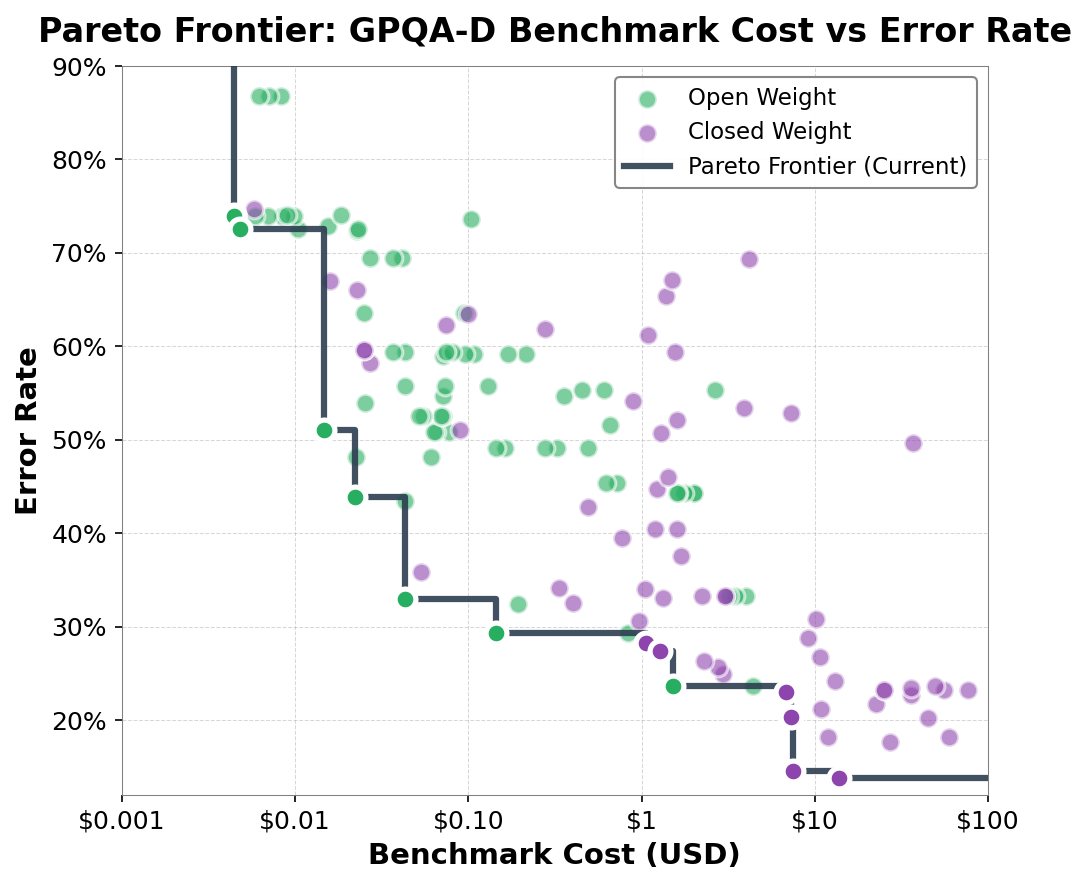

(<Figure size 1050x900 with 1 Axes>,
 <Axes: title={'center': 'Pareto Frontier: GPQA-D Benchmark Cost vs Error Rate'}, xlabel='Benchmark Cost (USD)', ylabel='Error Rate'>)

In [19]:
plot_pareto_curves(
    df,
    price_col='Benchmark Cost USD',
    benchmark_col='epoch_gpqa',
    color_by='open_weight',
    show_model_names=False,
    frontier_style='step',
    xmin= .001,
    xmax=100,
    ymin= .12,
    ymax=.9,
    title='Pareto Frontier: GPQA-D Benchmark Cost vs Error Rate',
    save_path='figures/pareto_gpqa_step.png'
)

## Example 2: GPQA-D with Model Names

Saved to: figures/pareto_gpqa_with_names.png


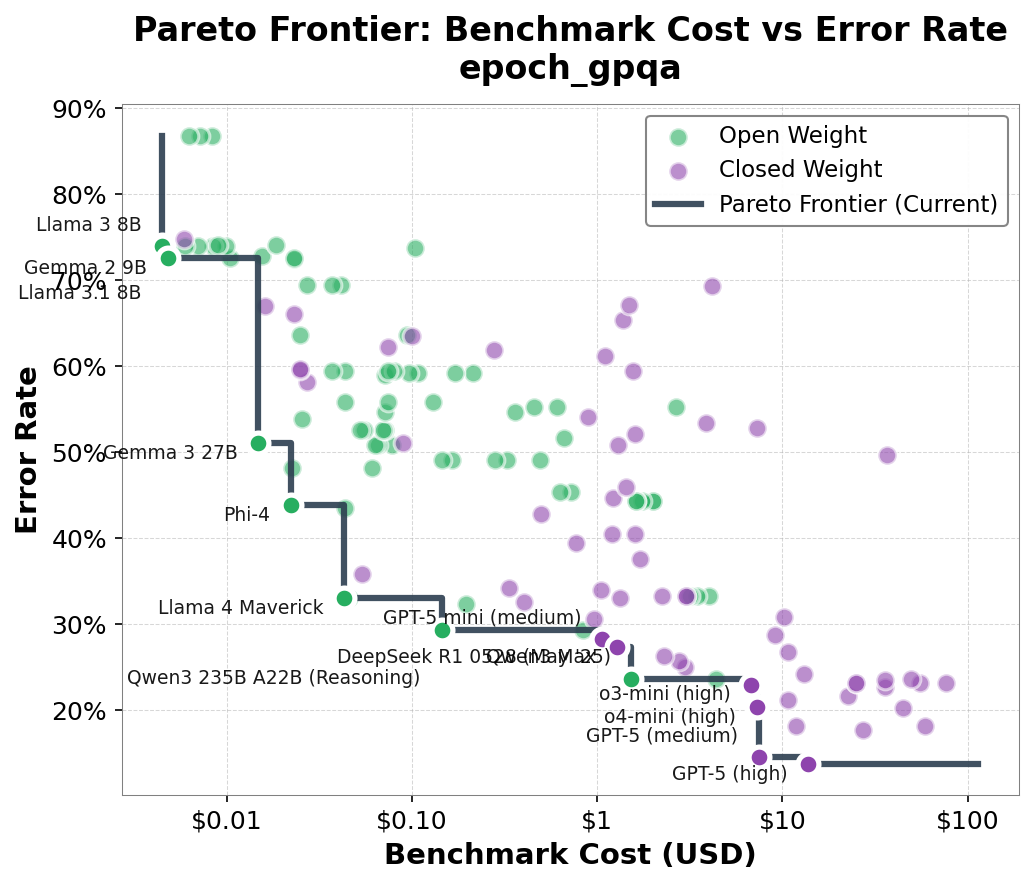

(<Figure size 1050x900 with 1 Axes>,
 <Axes: title={'center': 'Pareto Frontier: Benchmark Cost vs Error Rate\nepoch_gpqa'}, xlabel='Benchmark Cost (USD)', ylabel='Error Rate'>)

In [20]:
plot_pareto_curves(
    df,
    price_col='Benchmark Cost USD',
    benchmark_col='epoch_gpqa',
    color_by='open_weight',
    show_model_names=True,
    frontier_style='step',
    save_path='figures/pareto_gpqa_with_names.png'
)

In [21]:
# plot_pareto_curves(
#     df,
#     price_col='Benchmark Cost USD',
#     benchmark_col='epoch_gpqa',
#     color_by='moe',
#     moe_col='MoE',
#     show_model_names=False,
#     open_license_only=True,
#     frontier_style='step',
#     title='Pareto Frontier: GPQA-D\nDense vs MoE (Open Weight Only)',
#     save_path='figures/pareto_gpqa_moe_vs_dense.png'
# )

## Load AIME Data

In [22]:
# # Load AIME data
# df_aime = pd.read_csv('data/aime_price_reduction_models.csv')
# df_aime['MoE'] = df_aime['Known Active Parameters'].notna()
# print(f"Loaded {len(df_aime)} AIME models")
# print(f"Date range: {pd.to_datetime(df_aime['Release Date']).min()} to {pd.to_datetime(df_aime['Release Date']).max()}")

## Example 5: AIME with Step Function

In [23]:
# plot_pareto_curves(
#     df_aime,
#     price_col='Benchmark Cost USD',
#     benchmark_col='oneshot_AIME',
#     color_by='open_weight',
#     show_model_names=True,
#     frontier_style='step',
#     title='Pareto Frontier: AIME Benchmark Cost vs Error Rate',
#     save_path='figures/pareto_aime_step.png'
# )

# MOE Vs Dense

In [24]:
def plot_separate_moe_dense_frontiers(
    df,
    price_col='Benchmark Cost USD',
    benchmark_col='epoch_gpqa',
    moe_col='MoE',
    show_model_names=False,
    open_license_only=False,
    extend_frontier=True,  # New parameter to extend frontier lines
    min_xlim=None,
    xmin=None,
    xmax=None,
    ymin=None,
    ymax=None,
    figsize=(7.0, 6.0),  # Matching gpqa_pareto_names.py for ICML side-by-side
    title=None,
    save_path=None
):
    """
    Plot separate Pareto frontiers for MoE and Dense models on the same graph.
    
    Parameters:
        df: DataFrame containing model data
        price_col: Column name for benchmark price (x-axis)
        benchmark_col: Column name for benchmark score (will be converted to error rate)
        moe_col: Column name for MoE indicator (True/False)
        show_model_names: If True, display model names for Pareto frontier points
        open_license_only: If True, only include open-weight models
        extend_frontier: If True, extend frontier lines to cover full axis space
        min_xlim: Minimum x-axis limit (left bound). If None, uses automatic scaling. (Deprecated: use xmin instead)
        xmin: Minimum x-axis limit (left bound). If None, uses automatic scaling.
        xmax: Maximum x-axis limit (right bound). If None, uses automatic scaling.
        ymin: Minimum y-axis limit (bottom bound). If None, uses automatic scaling.
        ymax: Maximum y-axis limit (top bound). If None, uses automatic scaling.
        figsize: Figure size tuple (width, height)
        title: Custom title for the plot
        save_path: Optional path to save the figure
    
    Returns:
        fig, ax: matplotlib figure and axes objects
    """
    
    # Font size parameters (matching gpqa_pareto_names.py for ICML side-by-side)
    TICK_LABELSIZE = 12
    AXIS_LABELSIZE = 14
    AXIS_LABELWEIGHT = 'bold'
    TITLE_FONTSIZE = 16
    TITLE_FONTWEIGHT = 'bold'
    TITLE_PAD = 12
    LEGEND_FONTSIZE = 11
    ANNOTATE_FONTSIZE = 9
    POINT_SIZE_SCATTER = 80
    PARETO_POINT_SIZE = 100
    
    # Work on a copy
    df_work = df.copy()
    
    # Parse benchmark scores
    df_work[benchmark_col] = (
        df_work[benchmark_col].astype(str)
        .str.replace('%', '', regex=False)
        .str.strip()
    )
    df_work[benchmark_col] = pd.to_numeric(df_work[benchmark_col], errors='coerce')
    df_work['error_rate'] = 1 - (df_work[benchmark_col] / 100)
    
    # Parse prices
    df_work[price_col] = (
        df_work[price_col].astype(str)
        .str.replace('[$,]', '', regex=True)
    )
    df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')
    
    # Parse dates
    df_work['Release Date'] = pd.to_datetime(df_work['Release Date'])
    
    # Filter: open license
    if open_license_only:
        df_work = df_work[
            df_work['License'].notna() &
            df_work['License'].str.contains('open', case=False, na=False)
        ]
    
    # Drop rows with missing data
    df_work = df_work.dropna(subset=['Release Date', price_col, 'error_rate', moe_col])
    df_work = df_work[df_work[price_col] > 0]
    
    if len(df_work) == 0:
        print("No valid data to plot after filtering")
        return None, None
    
    # Get axis limits from all data
    # Use user-specified limits if provided, otherwise use data limits
    max_price = xmax if xmax is not None else df_work[price_col].max()
    max_error = ymax if ymax is not None else df_work['error_rate'].max()
    
    # Split data into MoE and Dense
    df_moe = df_work[df_work[moe_col] == True].copy()
    df_dense = df_work[df_work[moe_col] == False].copy()
    
    print(f"Total models: {len(df_work)}")
    print(f"MoE models: {len(df_moe)}")
    print(f"Dense models: {len(df_dense)}")
    
    # Set up the plot (matching gpqa_pareto_names.py style)
    plt.rcdefaults()
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['DejaVu Sans', 'Helvetica', 'Arial'],
        'font.size': 10,
    })
    
    fig, ax = plt.subplots(figsize=figsize, dpi=150)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Colors for MoE and Dense
    moe_color = '#E74C3C'  # Red
    dense_color = '#3498DB'  # Blue
    
    # Plot all points (scatter)
    if len(df_moe) > 0:
        ax.scatter(
            df_moe[price_col],
            df_moe['error_rate'],
            c=moe_color,
            s=POINT_SIZE_SCATTER,
            alpha=0.6,
            edgecolors='white',
            linewidth=1.5,
            label='MoE Models',
            zorder=3
        )
    
    if len(df_dense) > 0:
        ax.scatter(
            df_dense[price_col],
            df_dense['error_rate'],
            c=dense_color,
            s=POINT_SIZE_SCATTER,
            alpha=0.6,
            edgecolors='white',
            linewidth=1.5,
            label='Dense Models',
            zorder=3
        )
    
    # Calculate and plot MoE Pareto frontier
    if len(df_moe) > 0:
        pareto_moe = calculate_pareto_frontier(df_moe, price_col, 'error_rate')
        print(f"\nMoE Pareto frontier points: {len(pareto_moe)}")
        
        if len(pareto_moe) > 0:
            # Extend frontier if requested
            if extend_frontier:
                pareto_extended = pareto_moe.copy()
                
                # Add vertical extension (upward from leftmost point)
                leftmost_point = pareto_moe.iloc[0]
                if leftmost_point['error_rate'] < max_error:
                    vertical_point = pd.DataFrame([{
                        price_col: leftmost_point[price_col],
                        'error_rate': max_error,
                        'Model': ''
                    }])
                    pareto_extended = pd.concat([vertical_point, pareto_extended], ignore_index=True)
                
                # Add horizontal extension (rightward from rightmost point)
                rightmost_point = pareto_moe.iloc[-1]
                if rightmost_point[price_col] < max_price:
                    # If user specified xmax, extend to that; otherwise extend a bit beyond data max
                    extend_x = max_price if xmax is not None else max_price * 1.5
                    horizontal_point = pd.DataFrame([{
                        price_col: extend_x,
                        'error_rate': rightmost_point['error_rate'],
                        'Model': ''
                    }])
                    pareto_extended = pd.concat([pareto_extended, horizontal_point], ignore_index=True)
                
                pareto_plot = pareto_extended
            else:
                pareto_plot = pareto_moe
            
            # Build step function coordinates for MoE frontier
            prices = pareto_plot[price_col].values
            errors = pareto_plot['error_rate'].values
            step_x = []
            step_y = []
            for i in range(len(prices)):
                if i == 0:
                    step_x.append(prices[i])
                    step_y.append(errors[i])
                else:
                    # Horizontal segment first (same y, move to new x)
                    step_x.append(prices[i])
                    step_y.append(errors[i-1])
                    # Then vertical segment (at new x, drop to new y)
                    step_x.append(prices[i])
                    step_y.append(errors[i])
            
            ax.plot(
                step_x,
                step_y,
                color=moe_color,
                linestyle='-',
                linewidth=3,
                label='MoE Pareto Frontier',
                zorder=5,
                alpha=0.9
            )
            
            # Plot markers only for original Pareto points (not extensions)
            ax.scatter(
                pareto_moe[price_col],
                pareto_moe['error_rate'],
                c=moe_color,
                s=PARETO_POINT_SIZE,
                marker='o',
                edgecolors='white',
                linewidth=2.5,
                zorder=6,
                alpha=1.0
            )
            
            # Add model names if requested
            if show_model_names:
                import re
                
                def clean_model_name(name):
                    """Remove dates and clean up model names."""
                    if pd.isna(name):
                        return ''
                    name = str(name)
                    name = re.sub(r'\b\d{4}[-/]\d{1,2}[-/]\d{1,2}\b', '', name)
                    name = re.sub(r'\b\d{1,2}[-/]\d{1,2}[-/]\d{4}\b', '', name)
                    name = re.sub(r'\b(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s*\d{4}\b', '', name, flags=re.IGNORECASE)
                    name = re.sub(r'\b\d{4}\s*(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\b', '', name, flags=re.IGNORECASE)
                    name = re.sub(r'\s+20\d{2}\s*$', '', name)
                    name = re.sub(r'\s+', ' ', name).strip()
                    name = re.sub(r'[-_/]\s*$', '', name).strip()
                    return name
                
                # Collect labels for overlap detection
                moe_labels = []
                for _, row in pareto_moe.iterrows():
                    clean_name = clean_model_name(row['Model'])
                    if clean_name:
                        moe_labels.append({'name': clean_name, 'x': row[price_col], 'y': row['error_rate']})
                
                moe_labels.sort(key=lambda d: d['y'])
                placed_labels = []
                
                for label_info in moe_labels:
                    x_data, y_data, name = label_info['x'], label_info['y'], label_info['name']
                    x_offset, y_offset = -10, -5
                    
                    for placed in placed_labels:
                        if abs(y_data - placed['y']) < 0.025:
                            y_offset = -23 if y_offset > 0 else 10
                    
                    placed_labels.append({'x': x_data, 'y': y_data})
                    ax.annotate(
                        name, (x_data, y_data),
                        xytext=(x_offset, y_offset),
                        textcoords='offset points',
                        fontsize=ANNOTATE_FONTSIZE,
                        fontweight='medium',
                        alpha=0.9,
                        ha='right',
                        va='center',
                        color=moe_color,
                        zorder=7
                    )
    
    # Calculate and plot Dense Pareto frontier
    if len(df_dense) > 0:
        pareto_dense = calculate_pareto_frontier(df_dense, price_col, 'error_rate')
        print(f"Dense Pareto frontier points: {len(pareto_dense)}")
        
        if len(pareto_dense) > 0:
            # Extend frontier if requested
            if extend_frontier:
                pareto_extended = pareto_dense.copy()
                
                # Add vertical extension (upward from leftmost point)
                leftmost_point = pareto_dense.iloc[0]
                if leftmost_point['error_rate'] < max_error:
                    vertical_point = pd.DataFrame([{
                        price_col: leftmost_point[price_col],
                        'error_rate': max_error,
                        'Model': ''
                    }])
                    pareto_extended = pd.concat([vertical_point, pareto_extended], ignore_index=True)
                
                # Add horizontal extension (rightward from rightmost point)
                rightmost_point = pareto_dense.iloc[-1]
                if rightmost_point[price_col] < max_price:
                    # If user specified xmax, extend to that; otherwise extend a bit beyond data max
                    extend_x = max_price if xmax is not None else max_price * 1.5
                    horizontal_point = pd.DataFrame([{
                        price_col: extend_x,
                        'error_rate': rightmost_point['error_rate'],
                        'Model': ''
                    }])
                    pareto_extended = pd.concat([pareto_extended, horizontal_point], ignore_index=True)
                
                pareto_plot = pareto_extended
            else:
                pareto_plot = pareto_dense
            
            # Build step function coordinates for Dense frontier
            prices = pareto_plot[price_col].values
            errors = pareto_plot['error_rate'].values
            step_x = []
            step_y = []
            for i in range(len(prices)):
                if i == 0:
                    step_x.append(prices[i])
                    step_y.append(errors[i])
                else:
                    # Horizontal segment first (same y, move to new x)
                    step_x.append(prices[i])
                    step_y.append(errors[i-1])
                    # Then vertical segment (at new x, drop to new y)
                    step_x.append(prices[i])
                    step_y.append(errors[i])
            
            ax.plot(
                step_x,
                step_y,
                color=dense_color,
                linestyle='-',
                linewidth=3,
                label='Dense Pareto Frontier',
                zorder=5,
                alpha=0.9
            )
            
            # Plot markers only for original Pareto points (not extensions)
            ax.scatter(
                pareto_dense[price_col],
                pareto_dense['error_rate'],
                c=dense_color,
                s=PARETO_POINT_SIZE,
                marker='o',
                edgecolors='white',
                linewidth=2.5,
                zorder=6,
                alpha=1.0
            )
            
            # Add model names if requested
            if show_model_names:
                import re
                
                def clean_model_name(name):
                    """Remove dates and clean up model names."""
                    if pd.isna(name):
                        return ''
                    name = str(name)
                    name = re.sub(r'\b\d{4}[-/]\d{1,2}[-/]\d{1,2}\b', '', name)
                    name = re.sub(r'\b\d{1,2}[-/]\d{1,2}[-/]\d{4}\b', '', name)
                    name = re.sub(r'\b(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s*\d{4}\b', '', name, flags=re.IGNORECASE)
                    name = re.sub(r'\b\d{4}\s*(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\b', '', name, flags=re.IGNORECASE)
                    name = re.sub(r'\s+20\d{2}\s*$', '', name)
                    name = re.sub(r'\s+', ' ', name).strip()
                    name = re.sub(r'[-_/]\s*$', '', name).strip()
                    return name
                
                # Collect labels for overlap detection
                dense_labels = []
                for _, row in pareto_dense.iterrows():
                    clean_name = clean_model_name(row['Model'])
                    if clean_name:
                        dense_labels.append({'name': clean_name, 'x': row[price_col], 'y': row['error_rate']})
                
                dense_labels.sort(key=lambda d: d['y'])
                placed_labels = []
                
                for label_info in dense_labels:
                    x_data, y_data, name = label_info['x'], label_info['y'], label_info['name']
                    x_offset, y_offset = -10, -5
                    
                    for placed in placed_labels:
                        if abs(y_data - placed['y']) < 0.025:
                            y_offset = -23 if y_offset > 0 else 10
                    
                    placed_labels.append({'x': x_data, 'y': y_data})
                    ax.annotate(
                        name, (x_data, y_data),
                        xytext=(x_offset, y_offset),
                        textcoords='offset points',
                        fontsize=ANNOTATE_FONTSIZE,
                        fontweight='medium',
                        alpha=0.9,
                        ha='right',
                        va='center',
                        color=dense_color,
                        zorder=7
                    )
    
    # Set log scale for x-axis (price)
    ax.set_xscale('log')
    
    # Set axis limits if specified
    # Handle backward compatibility: if min_xlim is provided, use it for xmin
    if min_xlim is not None and xmin is None:
        xmin = min_xlim
    
    if xmin is not None or xmax is not None:
        current_xlim = ax.get_xlim()
        ax.set_xlim(left=xmin if xmin is not None else current_xlim[0],
                    right=xmax if xmax is not None else current_xlim[1])
    
    if ymin is not None or ymax is not None:
        current_ylim = ax.get_ylim()
        ax.set_ylim(bottom=ymin if ymin is not None else current_ylim[0],
                    top=ymax if ymax is not None else current_ylim[1])
    
    # Format axes
    from matplotlib.ticker import FuncFormatter, PercentFormatter
    
    def dollar_formatter(x, pos):
        if x >= 1:
            return f"${x:.0f}"
        elif x >= 0.01:
            return f"${x:.2f}"
        elif x >= 0.001:
            return f"${x:.3f}"
        else:
            return f"${x:.4f}"
    
    ax.xaxis.set_major_formatter(FuncFormatter(dollar_formatter))
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    
    # Labels and title
    ax.set_xlabel('Benchmark Cost (USD)', fontsize=AXIS_LABELSIZE, fontweight=AXIS_LABELWEIGHT)
    ax.set_ylabel('Error Rate', fontsize=AXIS_LABELSIZE, fontweight=AXIS_LABELWEIGHT)
    
    if title is None:
        benchmark_name = benchmark_col.split(' ')[0]
        plot_title = f'Separate Pareto Frontiers: MoE vs Dense Models\n{benchmark_name} Benchmark'
        if open_license_only:
            plot_title += ' (Open Weight Only)'
    else:
        plot_title = title
    
    ax.set_title(plot_title, fontsize=TITLE_FONTSIZE, fontweight=TITLE_FONTWEIGHT, pad=TITLE_PAD)
    
    # Grid (matching gpqa_pareto_names.py style)
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)
    
    # Disable x-axis minor ticks for cleaner look when side-by-side
    ax.tick_params(axis='x', which='minor', bottom=False)
    
    # Legend
    ax.legend(
        loc='upper right',
        fontsize=LEGEND_FONTSIZE,
        frameon=True,
        fancybox=True,
        framealpha=0.95,
        edgecolor='gray'
    )
    
    ax.tick_params(axis='both', which='major', labelsize=TICK_LABELSIZE)
    
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5)
    
    plt.tight_layout()
    
    # Save figure if requested
    if save_path is not None:
        import os
        output_dir = os.path.dirname(save_path)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir, exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\nFigure saved to: {save_path}")
    
    plt.show()
    
    return fig, ax

Total models: 75
MoE models: 16
Dense models: 59

MoE Pareto frontier points: 4
Dense Pareto frontier points: 5

Figure saved to: figures/moe_dense_pareto_gpqa_d.png


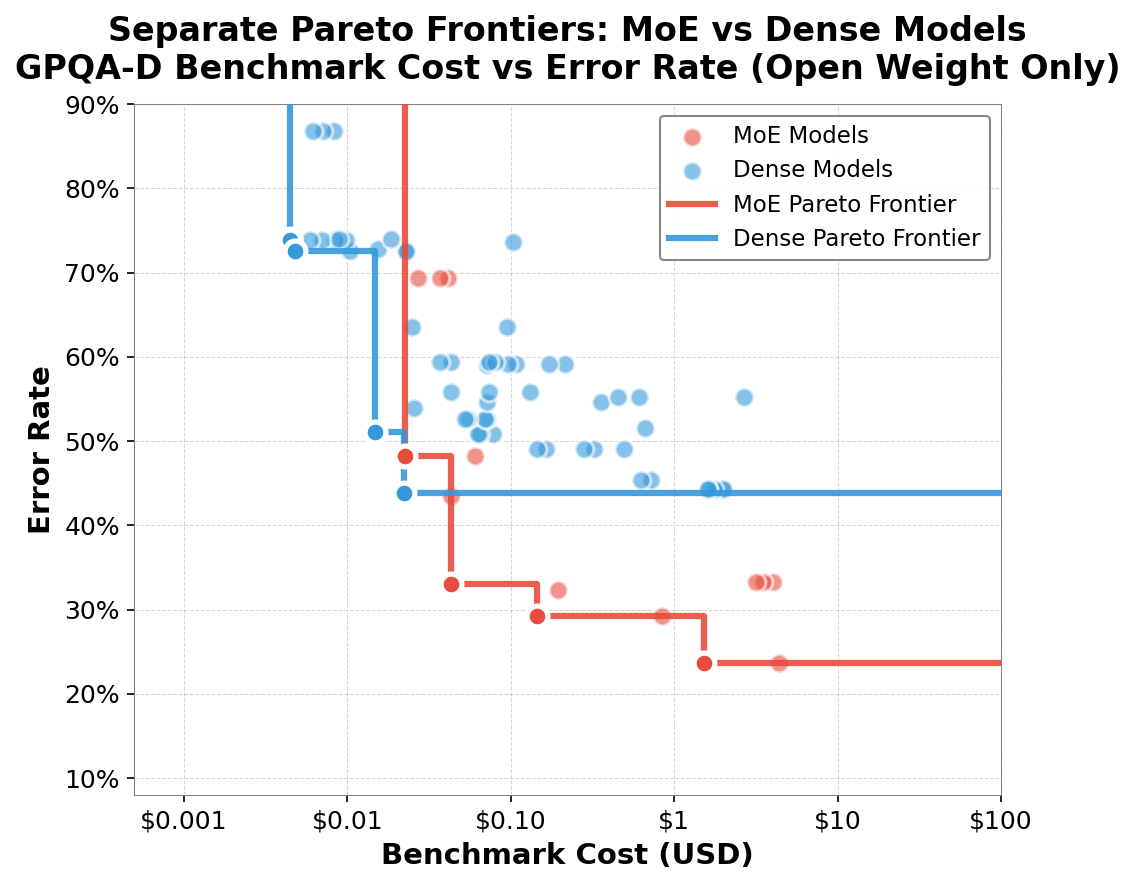

(<Figure size 1050x900 with 1 Axes>,
 <Axes: title={'center': 'Separate Pareto Frontiers: MoE vs Dense Models\nGPQA-D Benchmark Cost vs Error Rate (Open Weight Only)'}, xlabel='Benchmark Cost (USD)', ylabel='Error Rate'>)

In [25]:
# Plot separate Pareto frontiers for MoE vs Dense models - GPQA-D
# Open-weight models only with extended frontier lines
plot_separate_moe_dense_frontiers(
    df,
    price_col='Benchmark Cost USD',
    benchmark_col='epoch_gpqa',
    moe_col='MoE',
    show_model_names=False,
    open_license_only=True,  # Only include open-weight models
    extend_frontier=True,  # Extend frontier lines to cover full axis space
    xmin=0.001*0.5,
    xmax=100,
    ymin= .08,
    ymax=.9,
    title='Separate Pareto Frontiers: MoE vs Dense Models\nGPQA-D Benchmark Cost vs Error Rate (Open Weight Only)',
    save_path='figures/moe_dense_pareto_gpqa_d.png',
    
)